# Titanic

In [159]:
from pandas import DataFrame, Series, crosstab
import numpy as np
from collections import Counter
import math
import pandas as pd
from datetime import datetime, timedelta 

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold

<br>
<br>
### Loding training data and testing data

In [68]:
df = DataFrame.from_csv("res/train.csv")
test = DataFrame.from_csv("res/test.csv")
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<br>
### Type of feature
* Categorical Features: Sex, Embarked
* Ordinal Features: PClass(1/2/3等艙位)
* Continous Feature: Age


p.s.
* SibSp => 堂兄弟/妹個數
* Parch => 父母與小孩個數
* Ticket => 船票信息
* Fare => 票價
* Cabin => 客艙
* Embarked => 登船港口

In [69]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [70]:
#checking for total null values
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [71]:
survived = dict(Counter(df['Survived']))
survived.values()

dict_values([549, 342])

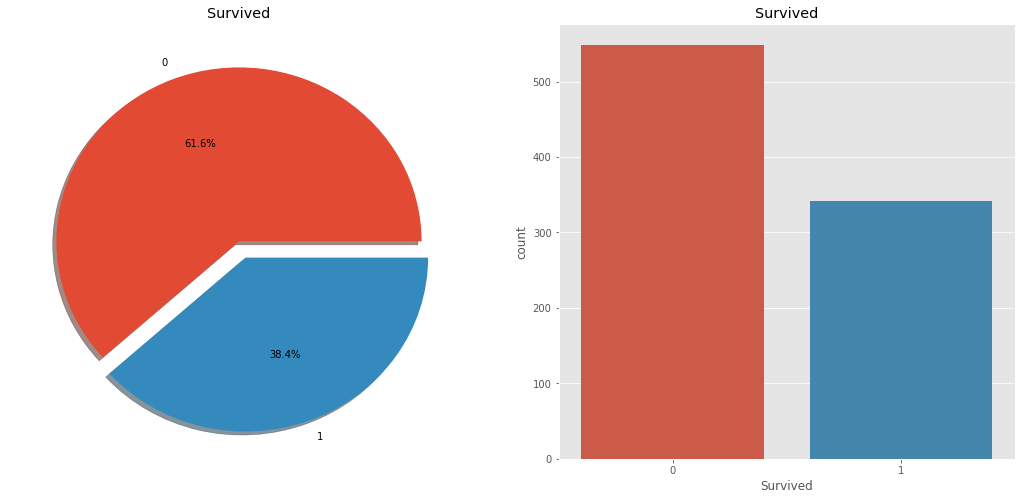

In [72]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=df,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

<br>
## Feature exploration

<br>
<b> Sex

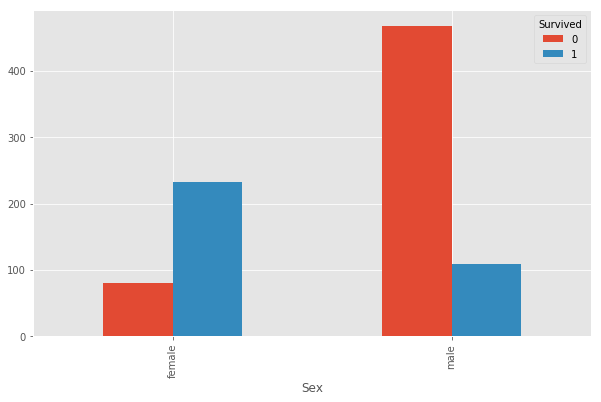

In [73]:
df_sex = crosstab(df['Sex'], df['Survived'])
df_sex.plot(kind='bar', figsize=(10,6))
# 印出關聯性大小 (correlation or sth.)

<br>
<b> Pclass

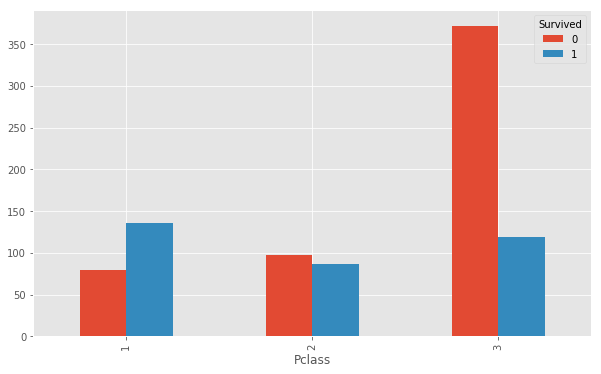

In [74]:
df_pclass = crosstab(df['Pclass'], df['Survived'])
df_pclass.plot(kind='bar', figsize=(10,6))

In [75]:
pd.crosstab(df.Pclass,df.Survived,margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


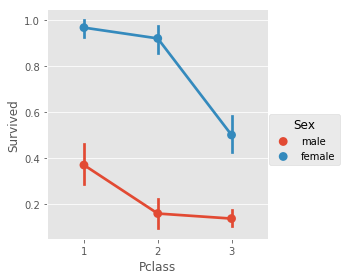

In [76]:
sns.factorplot('Pclass','Survived',hue='Sex',data=df)
plt.show()

<br>
<b> SibSp

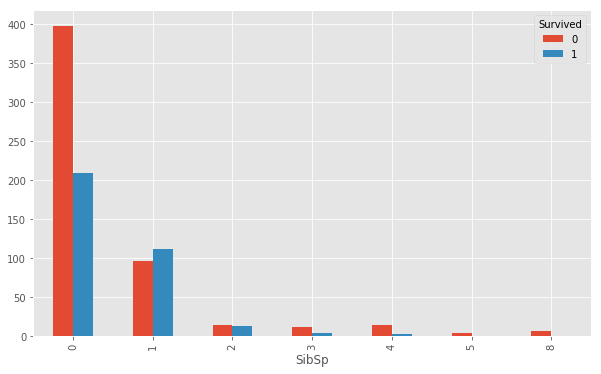

In [77]:
df_sibsp = crosstab(df['SibSp'], df['Survived'])
df_sibsp.plot(kind='bar', figsize=(10,6))

<br>
<b>Age

In [129]:
get_title = lambda x: x.split(', ')[1].split('.')[0]
df['Title'] = df['Name'].apply(get_title)
pd.crosstab(df.Sex,df.Title,margins=False).style.background_gradient(cmap='summer_r')

Title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,
female,0,0,0,1,0,1,0,0,182,2,1,0,125,1,0,0,1
male,1,2,1,6,1,0,2,40,0,0,0,517,0,0,6,1,0


In [130]:
df.groupby('Title')['Age'].mean()   # Average Age

Title
Capt            70.000000
Col             58.000000
Don             40.000000
Dr              42.000000
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           4.574167
Miss            21.773973
Mlle            24.000000
Mme             24.000000
Mr              32.368090
Mrs             35.898148
Ms              28.000000
Rev             43.166667
Sir             49.000000
the Countess    33.000000
Name: Age, dtype: float64

In [175]:
def transfer_title(x):
    if x in ['Dr','Major','Capt','Sir','Don']: return 'Mr_old'
    elif x in ['Lady','the Countess']: return 'Mrs'
    elif x in ['Mlle','Mme','Ms']: return 'Miss'
    elif x in ['Jonkheer','Col','Rev']: return 'Other'
    else: return x

df['Title'] = df['Title'].apply(transfer_title)
avg_age = df.groupby('Title')['Age'].mean()   # Average Age
avg_age

Title
Master     4.574167
Miss      21.860000
Mr        32.368090
Mr_old    46.181818
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [176]:
def fill_age(age, Name):
    title = get_title(Name)
    title = transfer_title(title)
    if math.isnan(age): return avg_age[title]
    else: return age

df['Age'] = [fill_age(age, title) for age, title in zip(df['Age'], df['Title'])]

IndexError: list index out of range

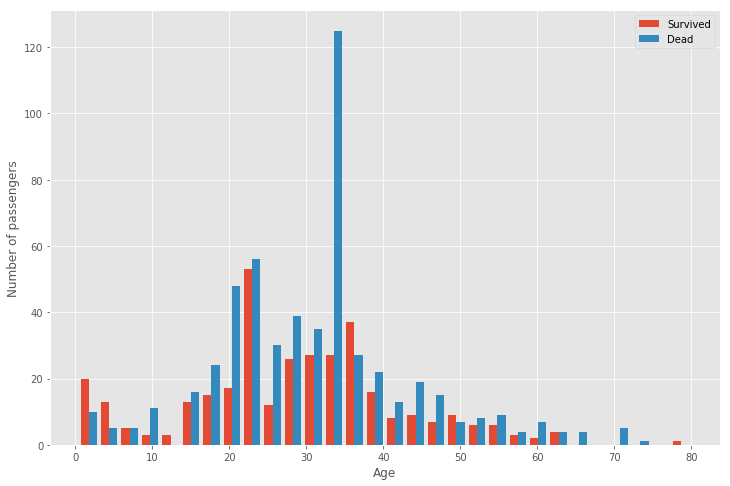

In [177]:
df['Dead'] = (df['Survived'] == 0).astype(int)
figure = plt.figure(figsize=(12,8))
plt.hist([df[df['Survived']==1]['Age'], df[df['Survived']==0]['Age']],
          bins = 30,label = ['Survived','Dead'])

plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

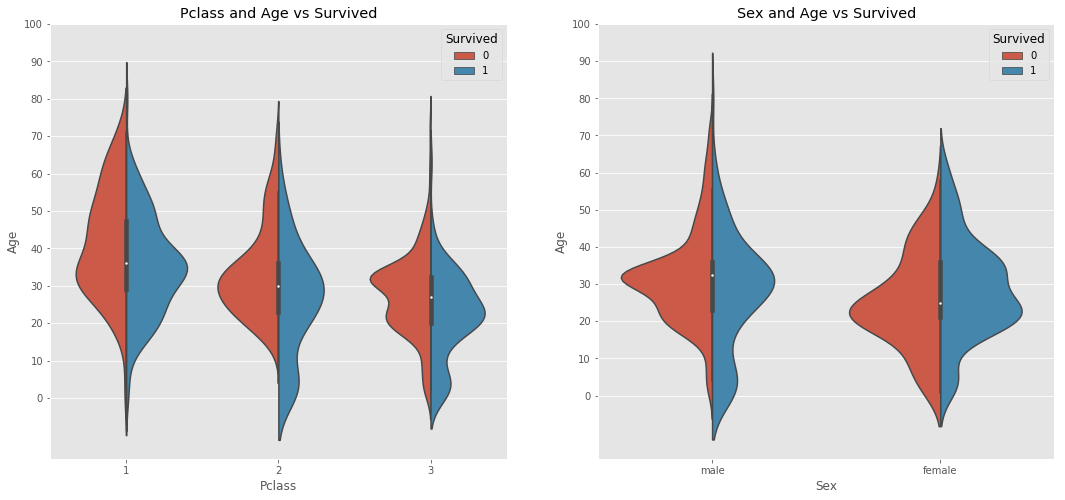

In [178]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=df,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age", hue="Survived", data=df,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

<br>
<b>Fare

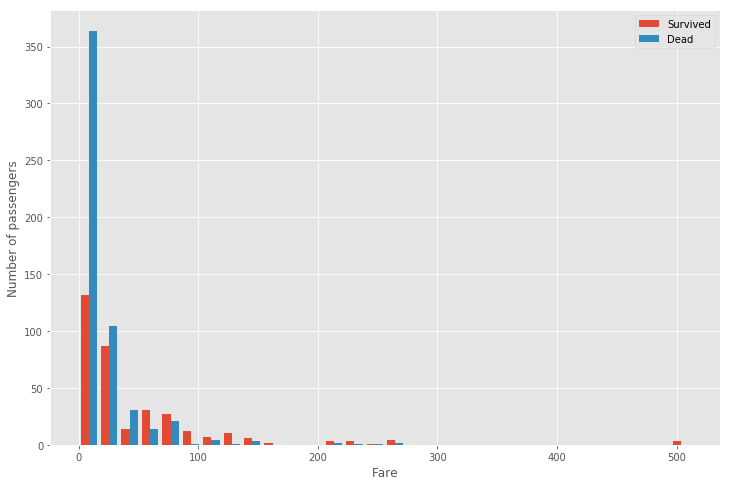

In [179]:
df['Dead'] = (df['Survived'] == 0).astype(int)
figure = plt.figure(figsize=(12,8))
plt.hist([df[df['Survived']==1]['Fare'], df[df['Survived']==0]['Fare']],
          bins = 30,label = ['Survived','Dead'])

plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()
del df['Dead']

In [180]:
def sex_translate(x):
    if x == 'male': return 0
    else: return 1
    
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.764424,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.280913,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.860000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.981818,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<br>
### Feature Process

In [181]:
def get_cabin(x):
    try:
        return 1
    except:
        return 0
    
def get_ticket(x):
    try:
        int(x[0])
        return 0
    except:
        return 1

In [182]:
def preprocess(df):
    df['Sex'] = df['Sex'].apply(sex_translate)
    df['Title'] = [int(get_title(x) == 'Mr') for x in df['Name']]
    df['Age'] = [fill_age(age, title) for age, title in zip(df['Age'], df['Name'])]
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    df['Embarked'] = [int(i == 'C') for i in df['Embarked']]
    df['Cabin'] = df['Cabin'].apply(get_cabin)
    df['Ticket'] = df['Ticket'].apply(get_ticket)
    del df['Name']
    del df['Cabin']
    del df['Ticket']
#    del df['Embarked']
    return df

label_column = 'Survived'
explore_feature = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Name', 'Cabin', 'Ticket']

<br>
### Random Forest Model

In [183]:
def get_RF_classifier(train_data, train_label, feature=[]):
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(train_data, train_label)
    feature_importance = DataFrame({'score': clf.feature_importances_}, index=feature)
    return clf, feature_importance

In [184]:
def count_acc(X_pred, y):
    c = Counter([i==j for i, j in zip(X_pred, y)])
    acc = c[1] / sum(c.values())
    return acc * 100

<br>
### K fold cross validation

In [187]:
FoldNum = 20

data = preprocess(df.loc[:, explore_feature])
X = data.values
y = df['Survived'].values
kf = KFold(n_splits=FoldNum, shuffle=True)
kf.get_n_splits(X)

print(kf)  

train_acc = dev_acc = feature_importance = 0

for train_index, dev_index in kf.split(X):
    
    X_train, X_dev = X[train_index], X[dev_index]
    y_train, y_dev = y[train_index], y[dev_index]
    
    clf, _feature_importance = get_RF_classifier(X_train, y_train, data.columns)
    
    X_train_pred = clf.predict(X_train)
    X_dev_pred = clf.predict(X_dev)
    
    train_acc += count_acc(X_train_pred, y_train)
    dev_acc += count_acc(X_dev_pred, y_dev)
    feature_importance += _feature_importance

print("train-set accuracy: %0.2f" % (train_acc/FoldNum))
print("dev-set accuracy: %0.2f\n" % (dev_acc/FoldNum))
print("Feature Importance:\n", feature_importance/FoldNum, "\n")

KFold(n_splits=20, random_state=None, shuffle=True)
train-set accuracy: 80.92
dev-set accuracy: 80.79

Feature Importance:
              score
Pclass    0.165541
Sex       0.136281
Age       0.011834
SibSp     0.072035
Parch     0.036538
Fare      0.033289
Embarked  0.002021
Title     0.542460 



<br>
<b>test-set

In [186]:
X_test = preprocess(test.loc[:, explore_feature])
test_pred = clf.predict(X_test.as_matrix())
result = DataFrame(test_pred, index=test.index, columns=['Survived'])
result.to_csv('result.csv')